## Machinery

This section defines some generic machinery for converting between colourspaces and working around some bugs in `colour-science`.

In [43]:
import colour #pip install colour-science
import numpy as np
import warnings
import json
from colour.utilities import from_range_100, from_range_degrees, to_domain_100, to_domain_degrees, tsplit, tstack

warnings.simplefilter("default", category=UserWarning)

### The CAT16 chromatic-adaptation transform

This is a two-step CAT16 transform per "Comparing two-step and one-step chromatic adaptation transforms using the CAT16 model", Li et. al. 2018.

In [44]:
CAT_CAT16 = np.matrix([
    [0.401288, 0.650173, -0.051461],
    [-0.250268, 1.204414, 0.045854],
    [-0.002079, 0.048952, 0.953127]])
CAT_INVERSE_CAT16 = np.linalg.inv(CAT_CAT16)

def chromatic_adaptation_CAT16(
    XYZ,
    XYZ_w1,
    XYZ_w2,
    L_A1=None,
    L_A2=None,
    surround1=colour.CAM16_VIEWING_CONDITIONS['Average'],
    surround2=colour.CAM16_VIEWING_CONDITIONS['Average']):

    XYZ = to_domain_100(XYZ)
    XYZ_w1 = to_domain_100(XYZ_w1)
    XYZ_w2 = to_domain_100(XYZ_w2)
    XYZ_we = np.array([100., 100., 100.])

    RGB_w1 = colour.utilities.dot_vector(CAT_CAT16, XYZ_w1)
    RGB_w2 = colour.utilities.dot_vector(CAT_CAT16, XYZ_w2)
    RGB_we = colour.utilities.dot_vector(CAT_CAT16, XYZ_we)

    D1 = surround1.F * (1. - (1/3.6) * np.exp((-L_A1 - 42.)/92.)) if L_A1 is not None else surround1.F
    D2 = surround2.F * (1. - (1/3.6) * np.exp((-L_A2 - 42.)/92.)) if L_A2 is not None else surround2.F
    
    G1 = np.diagflat(RGB_we / RGB_w1 * XYZ_w1[1] / XYZ_we[1] * D1 + 1. - D1)
    G2 = np.diagflat(RGB_w2 / RGB_we * XYZ_we[1] / XYZ_w2[1] * D2 + 1. - D2)

    transform = CAT_INVERSE_CAT16 * G2 * G1 * CAT_CAT16

    XYZ_c = colour.utilities.dot_vector(transform, XYZ)

    return from_range_100(XYZ_c)

### Viewing environment

This next section defines the `ViewingEnvironment` structure, which will be a parameter to many of the color-conversion functions that follow. Its fields are as follows:

* `rgb_colourspace`: The RGB colourspace that we're targeting, most likely sRGB. This is an instance of the `colour.RGB_Colourspace` type.
* `ambient_illuminance`: The illuminance level of the environment surrounding the screen, in lux.
* `ambient_lightness`: A CIE1976 $L^*$ value giving the average lightness of the environment surrounding the screen.
* `white_screen_luminance`: The luminance of a screen filled with `#ffffff`, in cd/m^2.
* `background_lightness`: A CIE1976 $L^*$ value giving the expected average lightness of the image displayed on the screen.
* `glare`: The percentage of ambient light reflected by a black LCD screen.
* `leakage`: The percentage of light from the monitor backlight that escapes through an LCD displaying `#000000`.

`ambient_lightness`, `background_lightness`, `glare`, and `leakage` have a scale of $[0,100]$ if `colour-science` is configured for `Scale-Reference` and a scale of $[0,1]$ if configured for `Scale-1`. They are implemented as magic attributes that accept and return values appropriate to whatever scale is in use. *E.g.,* if you set `ambient_lightness` to `50` while Scale-Reference is in use and then you switch to Scale-1, future field accesses will return `0.5`.

In [45]:
class ViewingEnvironment:
    def __init__(self, rgb_colourspace, ambient_whitepoint, ambient_illuminance, ambient_lightness, simulated_whitepoint, simulated_ambient_illuminance, simulated_ambient_lightness, white_screen_luminance, background_lightness, glare, leakage):
        self.rgb_colourspace = rgb_colourspace
        self.ambient_whitepoint = ambient_whitepoint
        self.ambient_illuminance = ambient_illuminance
        self._ambient_lightness = to_domain_100(ambient_lightness)
        self.simulated_whitepoint = simulated_whitepoint
        self.simulated_ambient_illuminance = simulated_ambient_illuminance
        self._simulated_ambient_lightness = to_domain_100(simulated_ambient_lightness)
        self.white_screen_luminance = white_screen_luminance
        self._background_lightness = to_domain_100(background_lightness)
        self._glare = to_domain_100(glare)
        self._leakage = to_domain_100(leakage)
    
    def __setattr__(self, name, value):
        if name == "ambient_lightness":
            object.__setattr__(self, "_ambient_lightness", to_domain_100(value))
        elif name == "simulated_ambient_lightness":
            object.__setattr__(self, "_simulated_ambient_lightness", to_domain_100(value))    
        elif name == "background_lightness":
            object.__setattr__(self, "_background_lightness", to_domain_100(value))
        elif name == "glare":
            object.__setattr__(self, "_glare", to_domain_100(value))
        elif name == "leakage":
            object.__setattr__(self, "_leakage", to_domain_100(value))
        else:
            object.__setattr__(self, name, value)
    
    def __getattribute__(self, name):
        if name == "ambient_lightness":
            return from_range_100(object.__getattribute__(self, "_ambient_lightness").copy())
        if name == "simulated_ambient_lightness":
            return from_range_100(object.__getattribute__(self, "_simulated_ambient_lightness").copy())    
        elif name == "background_lightness":
            return from_range_100(object.__getattribute__(self, "_background_lightness").copy())
        elif name == "glare":
            return from_range_100(object.__getattribute__(self, "_glare").copy())
        elif name == "leakage":
            return from_range_100(object.__getattribute__(self, "_leakage").copy())
        else:
            return object.__getattribute__(self, name)

### Interpolation of viewing conditions

CAM16 models the incomplete adaptation that occurs when viewing a screen that is much brighter than its surrounding environment. Luo and Li define *surround ratio* as the luminance ratio of a white object in the surround to a white screen. They provide three sets of parameters appropriate to surround ratios of 0, 0.15, or >=0.2 and recommend
linearly interpolating between them. This function implements that interpolation. We modify the definition of surround ratio to be based on grays instead of whites: that is, we scale the numerator according `ambient_lightness` and the denominator according to `background_lightness`. The original recommendation assumes these lightnesses are equal and in this case our definitions become equivalant.

In [46]:
def CAM16_surround_ratio_to_conditions(surround_ratio):
    if surround_ratio >= 0.2:
        return colour.CAM16_VIEWING_CONDITIONS['Average']

    average = colour.CAM16_VIEWING_CONDITIONS['Average']
    dim = colour.CAM16_VIEWING_CONDITIONS['Dim']
    dark = colour.CAM16_VIEWING_CONDITIONS['Dark']
    
    if surround_ratio >= 0.15:
        F = dim.F + (average.F - dim.F) * (surround_ratio - 0.15)/0.05
        c = dim.c + (average.c - dim.c) * (surround_ratio - 0.15)/0.05
        N_c = dim.N_c + (average.N_c - dim.N_c) * (surround_ratio - 0.15)/0.05
    else:
        F = dark.F + (dim.F - dark.F) * surround_ratio/0.15
        c = dark.c + (dim.c - dark.c) * surround_ratio/0.15
        N_c = dark.N_c + (dim.N_c - dark.N_c) * surround_ratio/0.15
    
    return colour.appearance.CIECAM02_InductionFactors(F=F, c=c, N_c=N_c)

In [47]:
def CAM16_viewing_conditions(view):
    surround_gray = view.ambient_illuminance / np.pi * colour.luminance(view.ambient_lightness)
    device_gray = view.white_screen_luminance * colour.luminance(view.background_lightness)
    surround_ratio = surround_gray / device_gray

    return CAM16_surround_ratio_to_conditions(surround_ratio)

In [48]:
def flare(view):
    glare = (colour.xy_to_XYZ(view.ambient_whitepoint) * 100.) * \
        view.ambient_illuminance / np.pi * (to_domain_100(view.glare) / 100.) / \
        view.white_screen_luminance
    leakage = (colour.xy_to_XYZ(view.rgb_colourspace.whitepoint) * 100) * \
        (to_domain_100(view.leakage) / 100.)
    return from_range_100(glare + leakage)


### HEX -> RGB -> XYZ -> J'M'h

In [49]:
def HEX_to_RGB(HEX):
    return colour.notation.HEX_to_RGB(HEX)

In [50]:
def RGB_to_XYZ(RGB, view):
    XYZ = from_range_100(
        colour.RGB_to_XYZ(
            RGB,
            view.rgb_colourspace.whitepoint,
            None,
            view.rgb_colourspace.RGB_to_XYZ_matrix,
            None,
            view.rgb_colourspace.cctf_decoding
        ) * 100.
    )

    XYZ += flare(view)

    return chromatic_adaptation_CAT16(
        XYZ,
        colour.utilities.from_range_100(colour.xy_to_XYZ(view.rgb_colourspace.whitepoint) * 100.) + flare(view),
        colour.utilities.from_range_100(colour.xy_to_XYZ(view.simulated_whitepoint) * 100.),
        view.ambient_illuminance / np.pi * to_domain_100(colour.luminance(view.ambient_lightness)) / 100.,
        view.simulated_ambient_illuminance / np.pi * to_domain_100(colour.luminance(view.simulated_ambient_lightness)) / 100.,
        CAM16_viewing_conditions(view))

In [51]:
def XYZ_to_JpMph(XYZ, view):
    cam16 = colour.XYZ_to_CAM16(
        XYZ,
        RGB_to_XYZ([1.,1.,1.], view),
        view.simulated_ambient_illuminance / np.pi * to_domain_100(colour.luminance(view.simulated_ambient_lightness)) / 100.,
        to_domain_100(colour.luminance(view.background_lightness)))

    J = to_domain_100(cam16.J)
    M = to_domain_100(cam16.M)
    Q = to_domain_100(cam16.Q)

    Jp = (1.7 * J)/(1 + 0.007 * J) 
    Mp = np.log(1. + 0.0228 * M) / 0.0228

    return tstack([from_range_100(Jp), from_range_100(Mp), cam16.h])

In [52]:
def HEX_to_XYZ(HEX, view):
    RGB = HEX_to_RGB(HEX)
    return RGB_to_XYZ(RGB, view)

def HEX_to_JpMph(HEX, view):
    XYZ = HEX_to_XYZ(HEX, view)
    return XYZ_to_JpMph(XYZ, view)

def RGB_to_JpMph(RGB, view):
    XYZ = RGB_to_XYZ(RGB, view)
    return XYZ_to_JpMph(XYZ, view)

### J'M'h -> XYZ -> RGB -> HEX

In [53]:
def RGB_valid(RGB):
    return np.all(np.logical_and(np.greater_equal(RGB, 0.), np.less_equal(RGB, 1.)))

In [54]:
def JpMph_to_XYZ(JpMph, view):
    (Jp, Mp, h) = tsplit(JpMph)
    Jp = to_domain_100(Jp)
    Mp = to_domain_100(Mp)

    J = from_range_100(Jp / (1.7 - 0.007*Jp))
    M = from_range_100((np.exp(0.0228 * Mp) - 1.) / 0.0228)

    cam16 = colour.CAM16_Specification(J=J, M=M, h=h)
    return colour.CAM16_to_XYZ(
        cam16,
        RGB_to_XYZ([1,1,1], view),
        view.simulated_ambient_illuminance / np.pi * to_domain_100(colour.luminance(view.simulated_ambient_lightness)) / 100.,
        to_domain_100(colour.luminance(view.background_lightness)))

def XYZ_to_RGB(XYZ, view):
    XYZ = chromatic_adaptation_CAT16(
        XYZ,
        colour.utilities.from_range_100(colour.xy_to_XYZ(view.simulated_whitepoint) * 100.),
        colour.utilities.from_range_100(colour.xy_to_XYZ(view.rgb_colourspace.whitepoint) * 100.) + flare(view),
        view.simulated_ambient_illuminance / np.pi * to_domain_100(colour.luminance(view.simulated_ambient_lightness)) / 100.,
        view.ambient_illuminance / np.pi * to_domain_100(colour.luminance(view.ambient_lightness)) / 100.,
        surround2=CAM16_viewing_conditions(view))

    XYZ -= flare(view)

    return colour.XYZ_to_RGB(
        to_domain_100(XYZ) / 100.,
        None,
        view.rgb_colourspace.whitepoint,
        view.rgb_colourspace.XYZ_to_RGB_matrix,
        None,
        view.rgb_colourspace.cctf_encoding)

def RGB_to_HEX(RGB):
    if not RGB_valid(RGB):
        warnings.warn("Clipping out-of-bounds RGB values")
        RGB = np.clip(RGB, 0., 1.)
    return colour.notation.RGB_to_HEX(RGB)

In [55]:
def JpMph_to_RGB(JpMph, view):
    XYZ = JpMph_to_XYZ(JpMph, view)
    return XYZ_to_RGB(XYZ, view)

def JpMph_to_HEX(JpMph, view):
    RGB = JpMph_to_RGB(JpMph, view)
    return RGB_to_HEX(RGB)

def XYZ_to_HEX(XYZ, view):
    RGB = XYZ_to_RGB(XYZ, view)
    return RGB_to_HEX(RGB)

### Additional color metrics

Contrast ratio, factoring in the relative luminance of a blank screen (flare) due to ambient light reflection and backlight leakage. This aligns the WCAG definition of contrast ratio iff these factors come out to 0.05.

In [56]:
def contrast_ratio(XYZ1, XYZ2, view):
    _, Y1, _ = tsplit(to_domain_100(XYZ1))
    _, Y2, _ = tsplit(to_domain_100(XYZ2))

    Ymax = np.maximum(Y1, Y2)
    Ymin = np.minimum(Y1, Y2)

    return  Ymax/Ymin

Compute hue angle from hue quadrature. Having this function is a little overkill because we're only going to end up calling it with the four cardinal hues.

In [57]:
def quadrature_to_hue(H):
    H = to_domain_100(H) % 400.
    hues = np.array([20.14, 90.00, 164.25, 237.53, 380.14])
    eccentricities = np.array([0.8, 0.7, 1.0, 1.2, 0.8])
    i = np.floor(H / 100.).astype(int)

    h_i = hues[i]
    h_j = hues[i+1]
    e_i = eccentricities[i]
    e_j = eccentricities[i+1]
    H_i = 100. * i

    h = ((H - H_i) * (e_j*h_i - e_i*h_j) - 100.*h_i*e_j)/((H - H_i) * (e_j-e_i) - 100.*e_j)
    return from_range_degrees(h % 360.)

def hue_to_quadrature(h):
    H = colour.appearance.ciecam02.hue_quadrature(to_domain_degrees(h))
    return from_range_100(H)

def warmness(H):
    H = to_domain_100(H) % 400.
    if H < 100:
        return H/100.
    elif H < 300:
        return (200-H)/100.
    else:
        return (H-400.)/100.

### Utilities for displaying color swatches

In [58]:
def display_RGB(RGB):
    RGB = np.array(RGB)
    if not RGB_valid(RGB):
        warnings.warn("Clipping out-of-bounds RGB values")
        RGB = np.clip(RGB, 0., 1.)
    swatches = [ colour.plotting.ColourSwatch(RGB=col) for col in RGB]
    colour.plotting.plot_multi_colour_swatches(swatches)

def display_HEX(HEX):
    display_RGB(HEX_to_RGB(HEX))

def display_XYZ(XYZ, view):
    display_RGB(XYZ_to_RGB(XYZ, view))

def display_JpMph(JpMph, view):
    display_RGB(JpMph_to_RGB(JpMph, view))

### Boundary search

In [59]:
def binary_search(a, b, threshold, pred):
    if b < a:
        (a,b) = (b,a)
    
    if pred(a) == pred(b):
        return None

    if pred(b):
        pred_neg = True
        my_pred = lambda x: not pred(x)
    else:
        pred_neg = False
        my_pred = pred

    while b-a > threshold:
        cur = (a+b)/2
        if my_pred(cur):
            a = cur
        else:
            b = cur
    if pred_neg:
        return b
    else:
        return a

In [60]:
def RGB_valid(RGB):
    return np.all(np.logical_and(np.greater_equal(RGB, 0.), np.less_equal(RGB, 1.)))

In [61]:
def find_colourfulness_limit(Jp, h, view):
    return binary_search(0., 1., 0.000001, lambda Mp: RGB_valid(JpMph_to_RGB([Jp, Mp, h], view)))

In [62]:
def find_saturation_limit(Jp, h, view):
    return find_colourfulness_limit(Jp, h, view) / np.sqrt(Jp)

In [63]:
def _decolor(JpMph, view):
    if RGB_valid(JpMph_to_RGB(JpMph, view)):
        return JpMph.copy()
    else:
        return np.array([JpMph[0], find_colourfulness_limit(JpMph[0], JpMph[2], view), JpMph[2]])

decolor = np.vectorize(_decolor, excluded=['view'], signature='(3),()->(3)')

## Light Theme

We're ready to start developing our light theme. From here on we're done developing our function library, so we'll switch to Scale-1 and assume it from here on.

In [64]:
colour.set_domain_range_scale('1')

We'll start with our seven neutral colors. Denote their relative luminances by $Y_0 \ldots Y_6$, their corresponding CIE1976 lightnesses by $L^*_0 \ldots L^*_6$, and their corresponding CAM16-UCS lightnesses, viewed against a background of $Y_5$, by $J'_0 \ldots J'_6$.

* $Y_0 = 0.05$, *i.e.,* the blackest black we can get away with if we want to be able to encode for an environment with 5% flare. This corresponds to an $L^*$ of about 26.7%.

* $L^*_5 = 0.92$. This is our main background color, and 92% is the lightness of good-quality book paper when it hasn't been artificially lightened by florescent dye.

* $L^*_2 = 0.35$.  This our main foreground color, which we want to resemble black ink. Black inks typcially have an $L^*$ of 25–35%. We'll go with 35% to give ourselves more breathing room to make $Y_1$ easily distinct from both $Y_0$ and $Y_2$.

* $J'_6 = J'_5 + 0.05$, so our emphasized background appears 5% lighter than our regular background.

* $J'_1 = J'_0 + 0.05$, for similar behavior from our inverse backgrounds (we're still assuming adaptation to the light background color since we expect this to dominant the display).

* $Y_4 = Y_1 Y_5 Y^{-1}_2$, giving our inverse scheme the same contrast ratio as our regular scheme.

* $Y_3 = \sqrt{Y_1 Y_5}$, giving it equal contrast with the regular and inverse backgrounds.

Before we go on to compute these, though, we need define our viewing environment because it's needed for converting in and out of CAM16-UCS space to obtain our $J'$ values.

* Our colorspace is sRGB, the standard for computer monitors and televisions.
* Our ambient whitepoint is D55, for mid-morning daylight through a window.
* Our ambient illuminance is 200 lux, on the dimmer side of what you get in a modern office building.
* Our ambient lightness is 50%, a good default assumption.
* Our simulated illuminant is D50, which resembles horizon light.
* Our simulated ambient illuminance is 1000 lux, like an overcast day.
* Our simulated ambient lightness is 50% again.
* Our screen luminance is 250 cd/m^2, well-matched to a 200 lux environment and a common maximum setting for low-end LCDs.
* Our background lightness is $L^*_5$ or  92%.
* Glare is 8.5%, per <http://www.sid.org/Portals/sid/Upper%20MidWest%20Chapter/PDF%20and%20Images/SID%202015%20TLM.pdf>.
* Leakage is 0.1%, corresponding to the 1:1000 contrast ratio you get from a low-end LCD.

If you adjust these values, be careful not to set the ambient illuminance too much brighter relative to the screen luminance. If flare exceeds 5%, this will push the black values out of bounds, because your screen is so washed-out by glare that we can't darken our colors enough to compensate. You might also encounter problems if you choose an extremely warm ambient illuminant such as A (tungsten bulb) or FL4 (warm white flourescent). We won't be able to remove enough red from our RGB values to make up for the excess of it that these bulbs shed.

In [65]:
LIGHT = ViewingEnvironment(
    rgb_colourspace=colour.RGB_COLOURSPACES['sRGB'],
    ambient_whitepoint=colour.ILLUMINANTS['CIE 1931 2 Degree Standard Observer']['D55'],
    ambient_illuminance=200.,
    ambient_lightness=0.5,
    simulated_whitepoint=colour.ILLUMINANTS['CIE 1931 2 Degree Standard Observer']['D50'],
    simulated_ambient_illuminance=1000.,
    simulated_ambient_lightness=0.5,
    white_screen_luminance=250.,
    background_lightness=0.92,
    glare=0.085,
    leakage=0.001
)

We'll never produce any colors such that $\frac{J'}{\sqrt{M'}}$ is greater than the following cap. In sRGB we take what we can get and the cap never limits us, but we want to avoid overdoing it if we're targeting a broader gamut.

In [66]:
LIGHT_saturation_cap = 0.35

def LIGHT_find_satuaration_limit(Jps, hs):
    return np.min( [ find_colourfulness_limit(Jp, h, LIGHT) / np.sqrt(Jp) for (Jp,h) in zip(Jps,hs) ] + [LIGHT_saturation_cap] )

In [67]:
# First fill in the three that are directly determined, using zero as a placehold for the rest. 
LIGHT_Ys = np.array([ 0.05, 0., colour.luminance(0.35), 0., 0., colour.luminance(0.92), 0. ])

LIGHT_Ys[1] =  \
    JpMph_to_XYZ(
        XYZ_to_JpMph(colour.xyY_to_XYZ([LIGHT.simulated_whitepoint[0], LIGHT.simulated_whitepoint[1], LIGHT_Ys[0]]), LIGHT) + [0.05, 0, 0],
        LIGHT
    )[0]

LIGHT_Ys[6] =  \
    JpMph_to_XYZ(
        XYZ_to_JpMph(colour.xyY_to_XYZ([LIGHT.simulated_whitepoint[0], LIGHT.simulated_whitepoint[1], LIGHT_Ys[5]]), LIGHT) + [0.05, 0, 0],
        LIGHT
    )[0]

LIGHT_Ys[4] = LIGHT_Ys[1] * LIGHT_Ys[5] / LIGHT_Ys[2]
LIGHT_Ys[3] = np.sqrt(LIGHT_Ys[1] * LIGHT_Ys[5])

That settles our $Y$. For $X$ and $Z$, we'll make our neutrals perfectly netural when viewed in our simulated D50 setting. But due to incomplete adaptation, they'll come out subtly warm when we encode into D65 for screen vieweing.

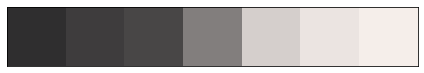

array(['#2e2d2f', '#3d3c3d', '#484646', '#827e7d', '#d5cecb', '#eae3e0',
       '#f5edea'], dtype=object)

In [68]:
LIGHT_neutral_XYZs = \
    [colour.xyY_to_XYZ([
        LIGHT.simulated_whitepoint[0],
        LIGHT.simulated_whitepoint[1],
        Y]) 
        for Y in LIGHT_Ys]

LIGHT_neutral_colors = XYZ_to_JpMph(LIGHT_neutral_XYZs, LIGHT)
LIGHT_Jps = LIGHT_neutral_colors[...,0]

display_JpMph(LIGHT_neutral_colors, LIGHT)

JpMph_to_HEX(LIGHT_neutral_colors, LIGHT)

Next we're going pick the hues of our foreground colors. These will be six hues at regular 60° steps around the CAM16-UCS color wheel. To choose our starting point, we take note of the common complaint that the sRGB gamut is very limited in the area of cyan. We arrange things such that when things get encoded back into sRGB at the end, we straddle that nadir as distantly as possible.

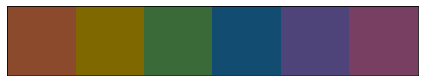

In [69]:
LIGHT_bad_color_XYZ = HEX_to_XYZ('#00ffff', LIGHT)

LIGHT_bad_hue = XYZ_to_JpMph(LIGHT_bad_color_XYZ, LIGHT)[2]
LIGHT_fg_hues = np.array([ (LIGHT_bad_hue + h/7.) % 1. for h in [ -3, -2, -1, 1, 2, 3] ])

#LIGHT_fg_hues = np.array([ (LIGHT_bad_hue + h/360.) % 1. for h in [ -148, -94, -40, 40, 94, 148] ])

LIGHT_fg_min_Jp = XYZ_to_JpMph(LIGHT_neutral_XYZs[2], LIGHT)[0]
LIGHT_fg_max_Jp = XYZ_to_JpMph(LIGHT_neutral_XYZs[5]/4.8, LIGHT)[0]

LIGHT_fg_vivid_Jps = np.array([  
    (LIGHT_fg_max_Jp + LIGHT_fg_min_Jp)/2. +
    (LIGHT_fg_max_Jp - LIGHT_fg_min_Jp)/2. *
    warmness(hue_to_quadrature(h))
    for h in LIGHT_fg_hues
])

LIGHT_fg_vivid_saturation_limit = LIGHT_find_satuaration_limit(LIGHT_fg_vivid_Jps, LIGHT_fg_hues)
LIGHT_fg_vivid_Mps = np.array([ np.sqrt(Jp) * LIGHT_fg_vivid_saturation_limit for  Jp in LIGHT_fg_vivid_Jps ])
LIGHT_fg_vivid_colors = np.array(list(zip(LIGHT_fg_vivid_Jps, LIGHT_fg_vivid_Mps, LIGHT_fg_hues)))

display_JpMph(LIGHT_fg_vivid_colors, LIGHT)

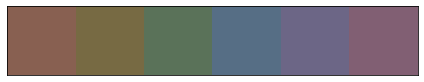

In [70]:
LIGHT_fg_soft_Jp = LIGHT_fg_max_Jp
LIGHT_fg_soft_Mp = np.sqrt(LIGHT_fg_soft_Jp) * LIGHT_fg_vivid_saturation_limit * 0.6
LIGHT_fg_soft_colors = np.array([[LIGHT_fg_soft_Jp, LIGHT_fg_soft_Mp, h] for h in LIGHT_fg_hues])

display_JpMph(LIGHT_fg_soft_colors, LIGHT)

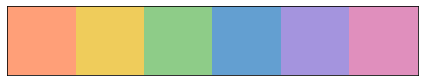

In [71]:
LIGHT_inverse_fg_min_Jp = XYZ_to_JpMph(LIGHT_neutral_XYZs[1]*4.8, LIGHT)[0]
LIGHT_inverse_fg_max_Jp = XYZ_to_JpMph(LIGHT_neutral_XYZs[4], LIGHT)[0]

LIGHT_inverse_fg_vivid_Jps = np.array([  
    (LIGHT_inverse_fg_max_Jp + LIGHT_inverse_fg_min_Jp)/2. +
    (LIGHT_inverse_fg_max_Jp - LIGHT_inverse_fg_min_Jp)/2. *
    warmness(hue_to_quadrature(h))
    for h in LIGHT_fg_hues
])

LIGHT_inverse_fg_vivid_saturation_limit = LIGHT_find_satuaration_limit(LIGHT_inverse_fg_vivid_Jps, LIGHT_fg_hues)
LIGHT_inverse_fg_vivid_Mps = np.array([ np.sqrt(Jp) * LIGHT_inverse_fg_vivid_saturation_limit for  Jp in LIGHT_inverse_fg_vivid_Jps ])
LIGHT_inverse_fg_vivid_colors = np.array(list(zip(LIGHT_inverse_fg_vivid_Jps, LIGHT_inverse_fg_vivid_Mps, LIGHT_fg_hues)))

display_JpMph(LIGHT_inverse_fg_vivid_colors, LIGHT)


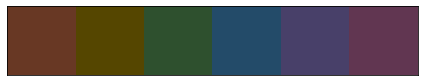

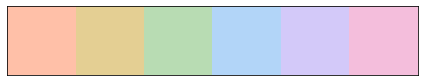

In [72]:
LIGHT_hc_Jp = XYZ_to_JpMph(LIGHT_neutral_XYZs[2], LIGHT)[0]
LIGHT_hc_Mp = np.min([ find_colourfulness_limit(LIGHT_hc_Jp, h, LIGHT) for h in LIGHT_fg_hues ])
LIGHT_hc_colors = np.array([ (LIGHT_hc_Jp, LIGHT_hc_Mp, h) for h in LIGHT_fg_hues  ])

LIGHT_inverse_hc_Jp = XYZ_to_JpMph(LIGHT_neutral_XYZs[4], LIGHT)[0]
LIGHT_inverse_hc_Mp = np.min([ find_colourfulness_limit(LIGHT_inverse_hc_Jp, h, LIGHT) for h in LIGHT_fg_hues ])
LIGHT_inverse_hc_colors = np.array([ (LIGHT_inverse_hc_Jp, LIGHT_inverse_hc_Mp, h) for h in LIGHT_fg_hues ])

display_JpMph(LIGHT_hc_colors, LIGHT)
display_JpMph(LIGHT_inverse_hc_colors, LIGHT)

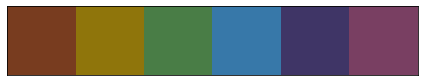

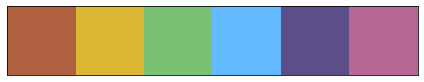

In [73]:
LIGHT_classic_terminal_contrast_range = \
    HEX_to_XYZ('#ffffff', LIGHT)[1] / HEX_to_XYZ('#000000', LIGHT)[1]

LIGHT_classic_terminal_high_logYs = np.log(HEX_to_XYZ(['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff', '#ff00ff'], LIGHT)[...,1])
LIGHT_classic_terminal_low_logYs = np.log(HEX_to_XYZ(['#800000', '#808000', '#008000', '#008080', '#000080', '#800080'], LIGHT)[...,1])

LIGHT_classic_terminal_logWhite = np.log(HEX_to_XYZ('#ffffff', LIGHT)[1])
LIGHT_classic_terminal_logBlack = np.log(HEX_to_XYZ('#000000', LIGHT)[1])

LIGHT_terminal_logWhite = np.log(LIGHT_Ys[5]/1.5)
LIGHT_terminal_logBlack = np.log(LIGHT_Ys[0])

LIGHT_terminal_high_Ys = np.exp(
    (LIGHT_classic_terminal_high_logYs - LIGHT_classic_terminal_logBlack) / \
    (LIGHT_classic_terminal_logWhite - LIGHT_classic_terminal_logBlack) * \
    (LIGHT_terminal_logWhite - LIGHT_terminal_logBlack) + LIGHT_terminal_logBlack
)

LIGHT_terminal_low_Ys = np.exp(
    (LIGHT_classic_terminal_low_logYs - LIGHT_classic_terminal_logBlack) / \
    (LIGHT_classic_terminal_logWhite - LIGHT_classic_terminal_logBlack) * \
    (LIGHT_terminal_logWhite - LIGHT_terminal_logBlack) + LIGHT_terminal_logBlack
)

LIGHT_terminal_high_Jps = XYZ_to_JpMph(colour.xyY_to_XYZ([
        (LIGHT.simulated_whitepoint[0], LIGHT.simulated_whitepoint[1], Y)
        for Y in LIGHT_terminal_high_Ys
    ]),
    LIGHT
)[...,0]

LIGHT_terminal_low_Jps = XYZ_to_JpMph(colour.xyY_to_XYZ([
        (LIGHT.simulated_whitepoint[0], LIGHT.simulated_whitepoint[1], Y)
        for Y in LIGHT_terminal_low_Ys
    ]),
    LIGHT
)[...,0]


LIGHT_terminal_saturation_limit = LIGHT_find_satuaration_limit(
    np.concatenate([LIGHT_terminal_low_Jps, LIGHT_terminal_high_Jps]),
    np.concatenate([LIGHT_fg_hues, LIGHT_fg_hues])
)

LIGHT_terminal_high_Mps = [ 
    np.sqrt(Jp) * LIGHT_terminal_saturation_limit
    for  Jp in LIGHT_terminal_high_Jps
]

LIGHT_terminal_low_Mps = [ 
    np.sqrt(Jp) * LIGHT_terminal_saturation_limit
    for  Jp in LIGHT_terminal_low_Jps
]

LIGHT_terminal_high_colors = list(zip(
    LIGHT_terminal_high_Jps,
    LIGHT_terminal_high_Mps,
    LIGHT_fg_hues
))

LIGHT_terminal_low_colors = list(zip(
    LIGHT_terminal_low_Jps,
    LIGHT_terminal_low_Mps,
    LIGHT_fg_hues
))

display_JpMph(LIGHT_terminal_low_colors, LIGHT)
display_JpMph(LIGHT_terminal_high_colors, LIGHT)

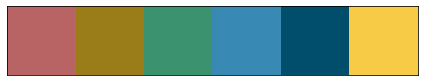

In [74]:
LIGHT_bg_hues = np.array([quadrature_to_hue(H) for H in [0,1,2,3,3,1] ])
LIGHT_bg_Jps = np.array([ LIGHT_Jps[i] for i in [3,3,3,3,2,4] ])
LIGHT_bg_saturation_limit = LIGHT_find_satuaration_limit(LIGHT_bg_Jps, LIGHT_bg_hues)
LIGHT_bg_Mps = np.array([ np.sqrt(Jp) * LIGHT_bg_saturation_limit for Jp in LIGHT_bg_Jps])
LIGHT_bg_colors = np.array(list(zip(LIGHT_bg_Jps, LIGHT_bg_Mps, LIGHT_bg_hues)))

display_JpMph(LIGHT_bg_colors, LIGHT)

## Dark Theme

Night sky spectral composition via <https://lavinia.as.arizona.edu/~minimaestro/MAESTRO/Construction/References/200076.web.pdf>

In [75]:
def ab_mag(m):
    return np.float_power(10., np.array(m) * -0.4)

night_sky_spectrum = (colour.sd_gaussian(445,94) * ab_mag(22.39) + \
    colour.sd_gaussian(551, 88) * ab_mag(21.19) + \
    colour.sd_gaussian(425, 3) * ab_mag(22.48) + \
    colour.sd_gaussian(455, 3) * ab_mag(22.18) + \
    colour.sd_gaussian(515, 3) * ab_mag(21.92)).normalise()

night_sky_xy = colour.XYZ_to_xy(
    colour.sd_to_XYZ_integration(night_sky_spectrum, colour.CMFS['CIE 1931 2 Degree Standard Observer'])
)

In [76]:
DARK = ViewingEnvironment(
    rgb_colourspace=colour.RGB_COLOURSPACES['sRGB'],
    ambient_whitepoint=colour.ILLUMINANTS['CIE 1931 2 Degree Standard Observer']['LED-B2'],
    ambient_illuminance=32.,
    ambient_lightness=0.5,
    simulated_whitepoint=colour.CCT_to_xy(4100),
    simulated_ambient_illuminance=0.05,
    simulated_ambient_lightness=0.5,
    white_screen_luminance=80.,
    background_lightness=None,
    glare=0.085,
    leakage=0.001
)

def DARK_set_background_lightness():
    def bgdiff(Yb):
        XYZ1 = colour.xyY_to_XYZ((night_sky_xy[0], night_sky_xy[1], 0.05))
        XYZ2 = colour.xyY_to_XYZ((night_sky_xy[0], night_sky_xy[1], Yb))
        DARK.background_lightness = colour.colorimetry.lightness_CIE1976(Yb)
        return XYZ_to_JpMph(XYZ2, DARK)[0] - XYZ_to_JpMph(XYZ1, DARK)[0]
    DARK.background_lightness = colour.colorimetry.lightness_CIE1976(binary_search(0., 1., 0.0001, lambda Yb: bgdiff(Yb) < 0.05))
DARK_set_background_lightness()

In [77]:
DARK_saturation_cap = 0.35

def DARK_find_satuaration_limit(Jps, hs):
    return np.min( [ find_colourfulness_limit(Jp, h, DARK) / np.sqrt(Jp) for (Jp,h) in zip(Jps,hs) ] + [DARK_saturation_cap] )

In [78]:
DARK_Ys = np.array([ 0.05, colour.luminance(DARK.background_lightness), 0., 0., 0., 0., 0.])

DARK_Ys[4] = LIGHT_Ys[4] * LIGHT_Ys[1]/DARK_Ys[1]
DARK_Ys[5] = LIGHT_Ys[5] * LIGHT_Ys[1]/DARK_Ys[1]
DARK_Ys[2] = DARK_Ys[1] * DARK_Ys[5] / DARK_Ys[4]
DARK_Ys[3] = np.sqrt(DARK_Ys[1] * DARK_Ys[5])
DARK_Ys[6] = JpMph_to_XYZ(
        XYZ_to_JpMph(colour.xyY_to_XYZ([DARK.simulated_whitepoint[0], DARK.simulated_whitepoint[1], DARK_Ys[5]]), DARK) + [0.05, 0, 0],
        DARK
    )[0]

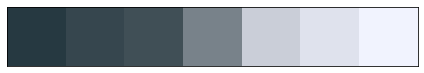

array(['#263941', '#35454d', '#3f4e56', '#78828a', '#c9ced8', '#dfe2ec',
       '#f1f3fe'], dtype=object)

In [79]:
DARK_neutral_colors = XYZ_to_JpMph([colour.xyY_to_XYZ([night_sky_xy[0], night_sky_xy[1], Y]) for Y in DARK_Ys], DARK)
for i in range(7):
    DARK_neutral_colors[i][1] *= 1 - np.sqrt(DARK_neutral_colors[i][0])


DARK_Jps = DARK_neutral_colors[...,0]
DARK_neutral_XYZs = JpMph_to_XYZ(DARK_neutral_colors, DARK)
display_JpMph(DARK_neutral_colors, DARK)

JpMph_to_HEX(DARK_neutral_colors, DARK)

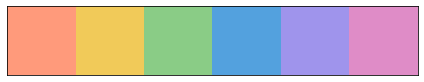

In [80]:
DARK_bad_color_XYZ = HEX_to_XYZ('#00ffff', DARK)

DARK_bad_hue = XYZ_to_JpMph(DARK_bad_color_XYZ, DARK)[2]

DARK_fg_hues = np.array([ (DARK_bad_hue + h/7.) % 1. for h in [ -3, -2, -1, 1, 2, 3] ])

DARK_fg_max_Jp = DARK_neutral_colors[4][0]
DARK_fg_min_Jp = XYZ_to_JpMph(DARK_neutral_XYZs[1]*4.8, DARK)[0]

DARK_fg_vivid_Jps = np.array([  
    (DARK_fg_max_Jp + DARK_fg_min_Jp)/2. +
    (DARK_fg_max_Jp - DARK_fg_min_Jp)/2. *
    warmness(hue_to_quadrature(h))
    for h in DARK_fg_hues
])

DARK_fg_vivid_saturation_limit = DARK_find_satuaration_limit(DARK_fg_vivid_Jps, DARK_fg_hues)
DARK_fg_vivid_Mps = np.array([ np.sqrt(Jp) * DARK_fg_vivid_saturation_limit for  Jp in DARK_fg_vivid_Jps ])
DARK_fg_vivid_colors = np.array(list(zip(DARK_fg_vivid_Jps, DARK_fg_vivid_Mps, DARK_fg_hues)))

display_JpMph(DARK_fg_vivid_colors, DARK)

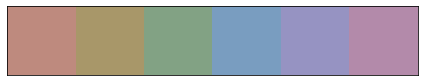

In [81]:
DARK_fg_soft_Jp = DARK_fg_min_Jp
DARK_fg_soft_Mp = np.sqrt(DARK_fg_soft_Jp) * DARK_fg_vivid_saturation_limit * 0.6
DARK_fg_soft_colors = np.array([[DARK_fg_soft_Jp, DARK_fg_soft_Mp, h] for h in DARK_fg_hues])

display_JpMph(DARK_fg_soft_colors, DARK)

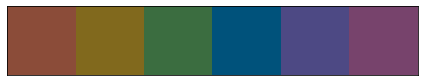

In [82]:
DARK_inverse_fg_min_Jp = XYZ_to_JpMph(DARK_neutral_XYZs[2], DARK)[0]
DARK_inverse_fg_max_Jp = XYZ_to_JpMph(DARK_neutral_XYZs[5]/4.8, DARK)[0]

DARK_inverse_fg_vivid_Jps = np.array([  
    (DARK_inverse_fg_max_Jp + DARK_inverse_fg_min_Jp)/2. +
    (DARK_inverse_fg_max_Jp - DARK_inverse_fg_min_Jp)/2. *
    warmness(hue_to_quadrature(h))
    for h in DARK_fg_hues
])

DARK_inverse_fg_vivid_saturation_limit = DARK_find_satuaration_limit(DARK_inverse_fg_vivid_Jps, DARK_fg_hues)
DARK_inverse_fg_vivid_Mps = np.array([ np.sqrt(Jp) * DARK_inverse_fg_vivid_saturation_limit for  Jp in DARK_inverse_fg_vivid_Jps ])
DARK_inverse_fg_vivid_colors = np.array(list(zip(DARK_inverse_fg_vivid_Jps, DARK_inverse_fg_vivid_Mps, DARK_fg_hues)))

display_JpMph(DARK_inverse_fg_vivid_colors, DARK)

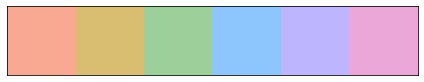

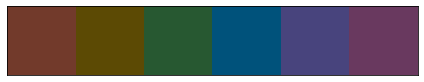

In [83]:
DARK_hc_Jp = XYZ_to_JpMph(DARK_neutral_XYZs[4], LIGHT)[0]
DARK_hc_Mp = np.min([ find_colourfulness_limit(DARK_hc_Jp, h, DARK) for h in DARK_fg_hues ])
DARK_hc_colors = np.array([ (DARK_hc_Jp, DARK_hc_Mp, h) for h in DARK_fg_hues  ])

DARK_inverse_hc_Jp = XYZ_to_JpMph(DARK_neutral_XYZs[2], DARK)[0]
DARK_inverse_hc_Mp = np.min([ find_colourfulness_limit(DARK_inverse_hc_Jp, h, DARK) for h in DARK_fg_hues ])
DARK_inverse_hc_colors = np.array([ (DARK_inverse_hc_Jp, DARK_inverse_hc_Mp, h) for h in DARK_fg_hues ])

display_JpMph(DARK_hc_colors, DARK)
display_JpMph(DARK_inverse_hc_colors, DARK)

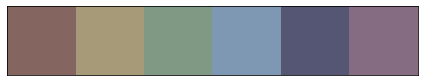

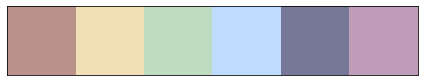

(array(['#84655f', '#a69978', '#809884', '#7d97b3', '#555672', '#856c82'], dtype=object),
 array(['#ba928b', '#f0dfb5', '#bedbc2', '#bddbfe', '#777697', '#be9db9'], dtype=object))

In [84]:
DARK_classic_terminal_contrast_range = \
    HEX_to_XYZ('#ffffff', DARK)[1] / HEX_to_XYZ('#000000', DARK)[1]

DARK_classic_terminal_high_logYs = np.log(HEX_to_XYZ(['#ff0000', '#ffff00', '#00ff00', '#00ffff', '#0000ff', '#ff00ff'], DARK)[...,1])
DARK_classic_terminal_low_logYs = np.log(HEX_to_XYZ(['#800000', '#808000', '#008000', '#008080', '#000080', '#800080'], DARK)[...,1])

DARK_classic_terminal_logWhite = np.log(HEX_to_XYZ('#ffffff', DARK)[1])
DARK_classic_terminal_logBlack = np.log(HEX_to_XYZ('#000000', DARK)[1])

DARK_terminal_logWhite = np.log(DARK_Ys[5])
DARK_terminal_logBlack = np.log(DARK_Ys[1])

DARK_terminal_high_Ys = np.exp(
    (DARK_classic_terminal_high_logYs - DARK_classic_terminal_logBlack) / \
    (DARK_classic_terminal_logWhite - DARK_classic_terminal_logBlack) * \
    (DARK_terminal_logWhite - DARK_terminal_logBlack) + DARK_terminal_logBlack
)

DARK_terminal_low_Ys = np.exp(
    (DARK_classic_terminal_low_logYs - DARK_classic_terminal_logBlack) / \
    (DARK_classic_terminal_logWhite - DARK_classic_terminal_logBlack) * \
    (DARK_terminal_logWhite - DARK_terminal_logBlack) + DARK_terminal_logBlack
)

DARK_terminal_high_Jps = XYZ_to_JpMph(colour.xyY_to_XYZ([
        (DARK.simulated_whitepoint[0], DARK.simulated_whitepoint[1], Y)
        for Y in DARK_terminal_high_Ys
    ]),
    DARK
)[...,0]

DARK_terminal_low_Jps = XYZ_to_JpMph(colour.xyY_to_XYZ([
        (DARK.simulated_whitepoint[0], DARK.simulated_whitepoint[1], Y)
        for Y in DARK_terminal_low_Ys
    ]),
    DARK
)[...,0]


DARK_terminal_saturation_limit = DARK_find_satuaration_limit(
    np.concatenate([DARK_terminal_low_Jps, DARK_terminal_high_Jps]),
    np.concatenate([DARK_fg_hues, DARK_fg_hues])
)

DARK_terminal_high_Mps = [ 
    np.sqrt(Jp) * DARK_terminal_saturation_limit
    for  Jp in DARK_terminal_high_Jps
]

DARK_terminal_low_Mps = [ 
    np.sqrt(Jp) * DARK_terminal_saturation_limit
    for  Jp in DARK_terminal_low_Jps
]

DARK_terminal_high_colors = list(zip(
    DARK_terminal_high_Jps,
    DARK_terminal_high_Mps,
    DARK_fg_hues
))

DARK_terminal_low_colors = list(zip(
    DARK_terminal_low_Jps,
    DARK_terminal_low_Mps,
    DARK_fg_hues
))

display_JpMph(DARK_terminal_low_colors, DARK)
display_JpMph(DARK_terminal_high_colors, DARK)

(JpMph_to_HEX(DARK_terminal_low_colors, DARK), JpMph_to_HEX(DARK_terminal_high_colors, DARK))

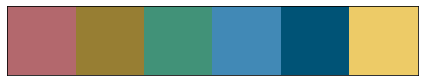

In [85]:

DARK_bg_hues = np.array([quadrature_to_hue(H) for H in [0,1,2,3,3,1] ])
DARK_bg_Jps = np.array([ DARK_Jps[i] for i in [3,3,3,3,2,4] ])
DARK_bg_saturation_limit = DARK_find_satuaration_limit(DARK_bg_Jps, DARK_bg_hues)
DARK_bg_Mps = np.array([ np.sqrt(Jp) * DARK_bg_saturation_limit for Jp in DARK_bg_Jps])
DARK_bg_colors = np.array(list(zip(DARK_bg_Jps, DARK_bg_Mps, DARK_bg_hues)))

display_JpMph(DARK_bg_colors, DARK)

## Eclipse theme

In [86]:
 ECLIPSE = ViewingEnvironment(
    rgb_colourspace=LIGHT.rgb_colourspace,
    ambient_whitepoint=LIGHT.ambient_whitepoint,
    ambient_illuminance=LIGHT.ambient_illuminance,
    ambient_lightness=LIGHT.ambient_lightness,
    simulated_whitepoint=DARK.simulated_whitepoint,
    simulated_ambient_illuminance=DARK.simulated_ambient_illuminance,
    simulated_ambient_lightness=DARK.simulated_ambient_lightness,
    white_screen_luminance=LIGHT.white_screen_luminance,
    background_lightness=DARK.background_lightness,
    glare=LIGHT.glare,
    leakage=LIGHT.leakage
)

ECLIPSE_neutral_colors = decolor(DARK_neutral_colors, ECLIPSE)
ECLIPSE_fg_soft_colors = decolor(DARK_fg_soft_colors, ECLIPSE)
ECLIPSE_fg_vivid_colors = decolor(DARK_fg_vivid_colors, ECLIPSE)
ECLIPSE_inverse_fg_vivid_colors = decolor(DARK_inverse_fg_vivid_colors, ECLIPSE)
ECLIPSE_hc_colors = decolor(DARK_hc_colors, ECLIPSE)
ECLIPSE_inverse_hc_colors = decolor(DARK_inverse_hc_colors, ECLIPSE)
ECLIPSE_terminal_low_colors = decolor(DARK_terminal_low_colors, ECLIPSE)
ECLIPSE_terminal_high_colors = decolor(DARK_terminal_high_colors, ECLIPSE)
ECLIPSE_bg_colors = decolor(DARK_bg_colors, ECLIPSE)

## Output

In [87]:
def fg_colors_to_dict(theme, prefix, colors):
    return dict(zip(
        [prefix + "Red", prefix + "Yellow", prefix + "Green", prefix + "Blue",  prefix + "Violet", prefix + "Magenta"],
        JpMph_to_RGB(colors, theme)))

def bg_colors_to_dict(theme, colors):
    return dict(zip(
        ["bgRed", "bgYellow", "bgGreen", "bgBlue", "bgDarkBlue", "bgLightYellow"],
        JpMph_to_RGB(colors, theme)))

def neutral_to_dict(theme, colors):
    d = dict(zip(
        ["deepBlack", "black", "darkGray", "mediumGray", "lightGray", "white", "brightWhite"],
        JpMph_to_RGB(colors, theme)))
    d["darkGrey"] = d["darkGray"]
    d["mediumGrey"] = d["mediumGray"]
    d["lightGrey"] = d["lightGray"]
    return d
    

In [88]:
LIGHT_theme = dict()
LIGHT_theme.update(fg_colors_to_dict(LIGHT, "soft", LIGHT_fg_soft_colors))
LIGHT_theme.update(fg_colors_to_dict(LIGHT, "vivid", LIGHT_fg_vivid_colors))
LIGHT_theme.update(fg_colors_to_dict(LIGHT, "invVivid", LIGHT_inverse_fg_vivid_colors))
LIGHT_theme.update(fg_colors_to_dict(LIGHT, "hc", LIGHT_hc_colors))
LIGHT_theme.update(fg_colors_to_dict(LIGHT, "invHc", LIGHT_inverse_hc_colors))
LIGHT_theme.update(fg_colors_to_dict(LIGHT, "termLow", LIGHT_terminal_low_colors))
LIGHT_theme.update(fg_colors_to_dict(LIGHT, "termHigh", LIGHT_terminal_high_colors))
LIGHT_theme.update(neutral_to_dict(LIGHT, LIGHT_neutral_colors))
LIGHT_theme.update(bg_colors_to_dict(LIGHT, LIGHT_bg_colors))
LIGHT_theme['emphBg'] = LIGHT_theme['brightWhite']
LIGHT_theme['bg'] = LIGHT_theme['white']
LIGHT_theme['deEmphBg'] = LIGHT_theme['lightGray']
LIGHT_theme['deEmphFg'] = LIGHT_theme['mediumGray']
LIGHT_theme['fg'] = LIGHT_theme['darkGray']
LIGHT_theme['emphFg'] = LIGHT_theme['black']
LIGHT_theme['invEmphBg'] = LIGHT_theme['deepBlack']
LIGHT_theme['invBg'] = LIGHT_theme['black']
LIGHT_theme['invDeEmphBg'] = LIGHT_theme['darkGray']
LIGHT_theme['invDeEmphFg'] = LIGHT_theme['mediumGray']
LIGHT_theme['invFg'] = LIGHT_theme['lightGray']
LIGHT_theme['invEmphFg'] = LIGHT_theme['white']
LIGHT_theme['bgHighlight'] = LIGHT_theme['bgLightYellow']
LIGHT_theme['bgLowlight'] = LIGHT_theme['bgDarkBlue']
LIGHT_theme['_name'] = "Lunaria Light"
LIGHT_theme['_type'] = "light"

In [89]:
DARK_theme = dict()
DARK_theme.update(fg_colors_to_dict(DARK, "soft", DARK_fg_soft_colors))
DARK_theme.update(fg_colors_to_dict(DARK, "vivid", DARK_fg_vivid_colors))
DARK_theme.update(fg_colors_to_dict(DARK, "invVivid", DARK_inverse_fg_vivid_colors))
DARK_theme.update(fg_colors_to_dict(DARK, "hc", DARK_hc_colors))
DARK_theme.update(fg_colors_to_dict(DARK, "invHc", DARK_inverse_hc_colors))
DARK_theme.update(fg_colors_to_dict(DARK, "termLow", DARK_terminal_low_colors))
DARK_theme.update(fg_colors_to_dict(DARK, "termHigh", DARK_terminal_high_colors))
DARK_theme.update(neutral_to_dict(DARK, DARK_neutral_colors))
DARK_theme.update(bg_colors_to_dict(DARK, DARK_bg_colors))
DARK_theme['emphBg'] = DARK_theme['deepBlack']
DARK_theme['bg'] = DARK_theme['black']
DARK_theme['deEmphBg'] = DARK_theme['darkGray']
DARK_theme['deEmphFg'] = DARK_theme['mediumGray']
DARK_theme['fg'] = DARK_theme['lightGray']
DARK_theme['emphFg'] = DARK_theme['white']
DARK_theme['invEmphBg'] = DARK_theme['brightWhite']
DARK_theme['invBg'] = DARK_theme['white']
DARK_theme['invDeEmphBg'] = DARK_theme['lightGray']
DARK_theme['invDeEmphFg'] = DARK_theme['mediumGray']
DARK_theme['invFg'] = DARK_theme['darkGray']
DARK_theme['invEmphFg'] = DARK_theme['black']
DARK_theme['bgHighlight'] = DARK_theme['bgDarkBlue']
DARK_theme['bgLowlight'] = DARK_theme['bgLightYellow']
DARK_theme['_name'] = "Lunaria Dark"
DARK_theme['_type'] = "dark"

In [90]:
ECLIPSE_theme = dict()
ECLIPSE_theme.update(fg_colors_to_dict(ECLIPSE, "soft", ECLIPSE_fg_soft_colors))
ECLIPSE_theme.update(fg_colors_to_dict(ECLIPSE, "vivid", ECLIPSE_fg_vivid_colors))
ECLIPSE_theme.update(fg_colors_to_dict(ECLIPSE, "invVivid", ECLIPSE_inverse_fg_vivid_colors))
ECLIPSE_theme.update(fg_colors_to_dict(ECLIPSE, "hc", ECLIPSE_hc_colors))
ECLIPSE_theme.update(fg_colors_to_dict(ECLIPSE, "invHc", ECLIPSE_inverse_hc_colors))
ECLIPSE_theme.update(fg_colors_to_dict(ECLIPSE, "termLow", ECLIPSE_terminal_low_colors))
ECLIPSE_theme.update(fg_colors_to_dict(ECLIPSE, "termHigh", ECLIPSE_terminal_high_colors))
ECLIPSE_theme.update(neutral_to_dict(ECLIPSE, ECLIPSE_neutral_colors))
ECLIPSE_theme.update(bg_colors_to_dict(ECLIPSE, ECLIPSE_bg_colors))
ECLIPSE_theme['emphBg'] = ECLIPSE_theme['deepBlack']
ECLIPSE_theme['bg'] = ECLIPSE_theme['black']
ECLIPSE_theme['deEmphBg'] = ECLIPSE_theme['darkGray']
ECLIPSE_theme['deEmphFg'] = ECLIPSE_theme['mediumGray']
ECLIPSE_theme['fg'] = ECLIPSE_theme['lightGray']
ECLIPSE_theme['emphFg'] = ECLIPSE_theme['white']
ECLIPSE_theme['invEmphBg'] = ECLIPSE_theme['brightWhite']
ECLIPSE_theme['invBg'] = ECLIPSE_theme['white']
ECLIPSE_theme['invDeEmphBg'] = ECLIPSE_theme['lightGray']
ECLIPSE_theme['invDeEmphFg'] = ECLIPSE_theme['mediumGray']
ECLIPSE_theme['invFg'] = ECLIPSE_theme['darkGray']
ECLIPSE_theme['invEmphFg'] = ECLIPSE_theme['black']
ECLIPSE_theme['bgHighlight'] = ECLIPSE_theme['bgDarkBlue']
ECLIPSE_theme['bgLowlight'] = ECLIPSE_theme['bgLightYellow']
ECLIPSE_theme['_name'] = "Lunaria Eclipse"
ECLIPSE_theme['_type'] = "dark"

In [91]:
json.dump(LIGHT_theme, open('./lunaria-light.json', 'w'), default=lambda o: list(iter(o)))
json.dump(DARK_theme, open('./lunaria-dark.json', 'w'), default=lambda o: list(iter(o)))
json.dump(ECLIPSE_theme, open('./lunaria-eclipse.json', 'w'), default=lambda o: list(iter(o)))